# Sampling Methods for Language Models

In this notebook, we'll explore different sampling strategies for decoder-only transformer models. These strategies include:

1. Greedy Sampling
2. Temperature Sampling
3. Top-K Sampling
4. Top-p (Nucleus) Sampling
5. Beam Search
6. Repetition Penalty

We'll use toy examples with logit calculations from decoder-only transformer models to illustrate how each sampling method works.

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import random
import math
from typing import List, Dict, Tuple, Optional

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Toy Example Setup: Decoder-Only Transformer

To illustrate sampling methods, we'll create a simplified setup that represents the output logits from a decoder-only transformer. We'll use a small vocabulary to make visualization easier.

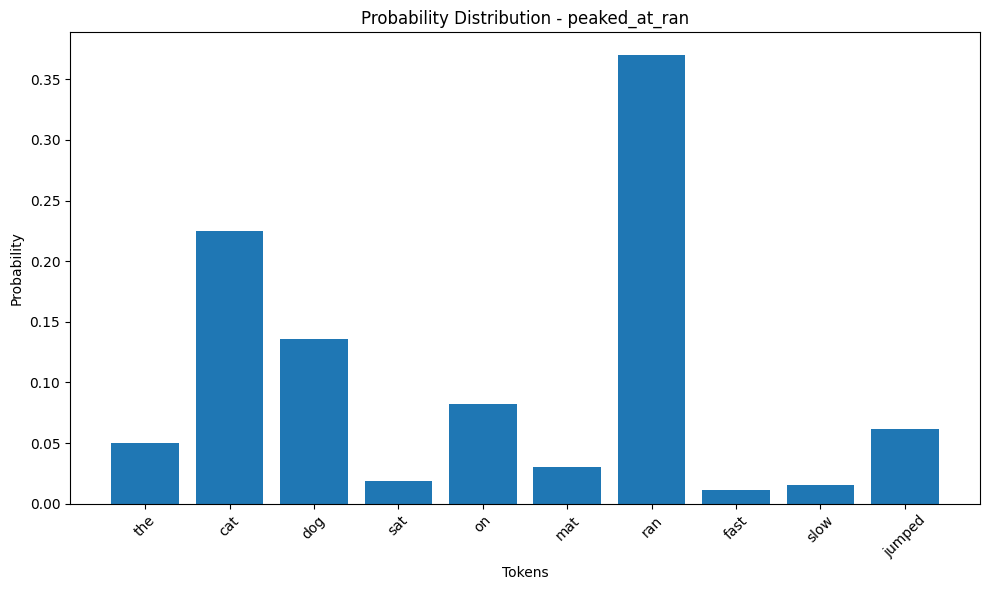

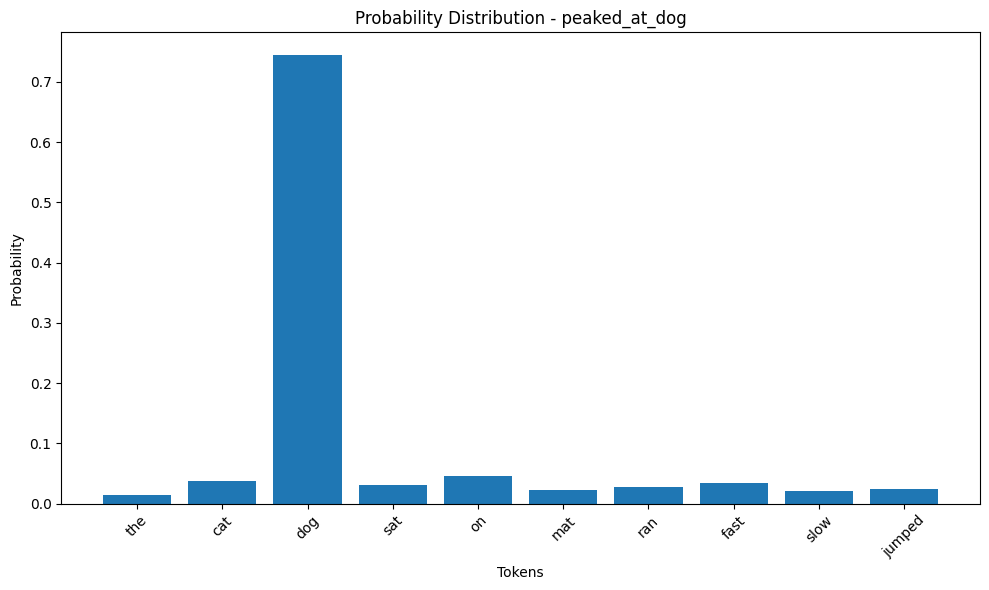

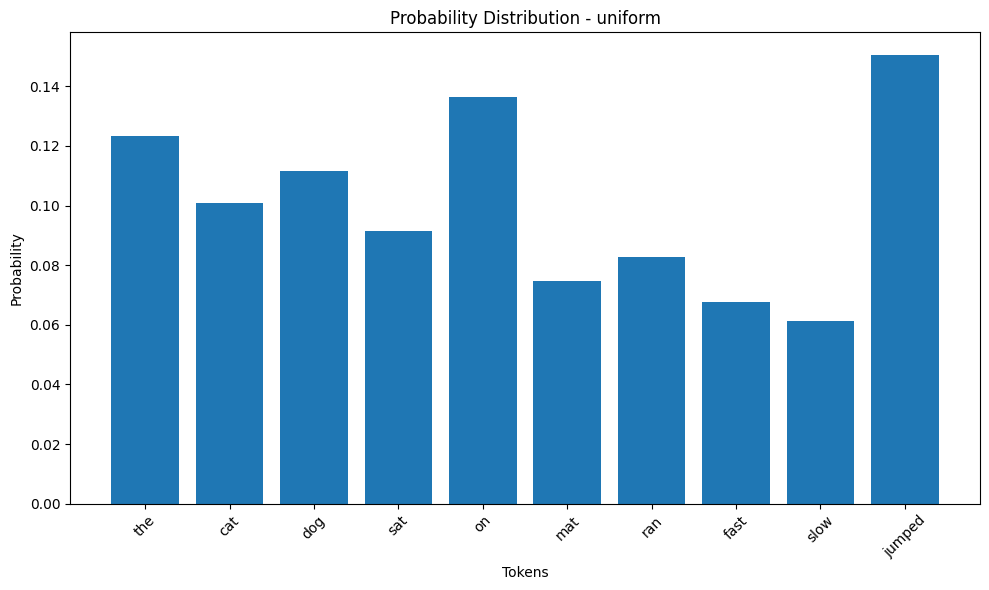

In [3]:
# Define a small vocabulary for our toy examples
vocab = ['the', 'cat', 'dog', 'sat', 'on', 'mat', 'ran', 'fast', 'slow', 'jumped']
vocab_size = len(vocab)

# Function to convert tokens to IDs and vice versa
def token_to_id(token: str) -> int:
    return vocab.index(token) if token in vocab else -1

def id_to_token(id: int) -> str:
    return vocab[id] if 0 <= id < len(vocab) else "<UNK>"

# Generate sample logits as if they were from the last layer of a transformer model
# These represent unnormalized log probabilities for the next token
def generate_sample_logits() -> torch.Tensor:
    # Create logits with different distributions for demonstration
    logits_1 = torch.tensor([2.0, 3.5, 3.0, 1.0, 2.5, 1.5, 4.0, 0.5, 0.8, 2.2])  # Peaked at 'ran'
    logits_2 = torch.tensor([1.0, 2.0, 5.0, 1.8, 2.2, 1.5, 1.7, 1.9, 1.4, 1.6])  # Peaked at 'dog'
    logits_3 = torch.tensor([3.0, 2.8, 2.9, 2.7, 3.1, 2.5, 2.6, 2.4, 2.3, 3.2])  # More uniform
    
    return {"peaked_at_ran": logits_1, 
            "peaked_at_dog": logits_2, 
            "uniform": logits_3}

# Get sample logits
sample_logits = generate_sample_logits()

# Function to visualize the probability distribution
def visualize_distribution(distribution, title="Probability Distribution"):
    plt.figure(figsize=(10, 6))
    plt.bar(vocab, distribution.numpy())
    plt.xlabel('Tokens')
    plt.ylabel('Probability')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Convert logits to probabilities using softmax
def logits_to_probs(logits):
    return F.softmax(logits, dim=-1)

# Display the base distributions
for name, logits in sample_logits.items():
    probs = logits_to_probs(logits)
    visualize_distribution(probs, f"Probability Distribution - {name}")

## Self-Attention and Logit Generation in Transformer Models

Before diving into sampling methods, let's briefly review how logits are generated in a decoder-only transformer model using self-attention.

In a transformer decoder, each token attends to all previous tokens through self-attention. The final layer produces logits which represent the model's prediction for the next token. Here's a simplified implementation of self-attention and the process that generates logits.

In [4]:
class SimplifiedSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        # Linear projections for Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        
        # Linear projections
        q = self.q_linear(x)
        k = self.k_linear(x)
        v = self.v_linear(x)
        
        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply causal mask (for decoder-only models)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention weights to values
        context = torch.matmul(attention_weights, v)
        
        # Reshape back to original dimensions
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Final linear projection
        output = self.out_linear(context)
        return output, attention_weights

class SimplifiedTransformerLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.self_attention = SimplifiedSelfAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
    def forward(self, x, mask=None):
        # Self-attention block
        attn_output, _ = self.self_attention(x, mask)
        x = self.norm1(x + attn_output)  # Add & Norm
        
        # Feed-forward block
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)  # Add & Norm
        
        return x

class ToyDecoderOnlyModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(100, d_model)  # Max 100 positions for simplicity
        
        self.layers = nn.ModuleList(
            [SimplifiedTransformerLayer(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        
        self.lm_head = nn.Linear(d_model, vocab_size)  # Linear layer to produce logits
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Create position indices
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(x.device)
        
        # Create embeddings
        token_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(positions)
        x = token_emb + pos_emb
        
        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        mask = ~mask  # Invert to get the causal mask (1 for positions to attend to)
        
        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x, mask)
        
        # Project to vocabulary size to get logits
        logits = self.lm_head(x)
        
        return logits

# For demonstration, we'll just use our pre-computed logits
# But this shows the process of how those logits would be generated in a real model

## 1. Greedy Sampling

Greedy sampling is the simplest approach: always select the token with the highest probability at each step. This is deterministic but often leads to repetitive and less diverse outputs.

Greedy Sampling Results:
  Distribution 'peaked_at_ran': Selected token 'ran' (ID: 6)


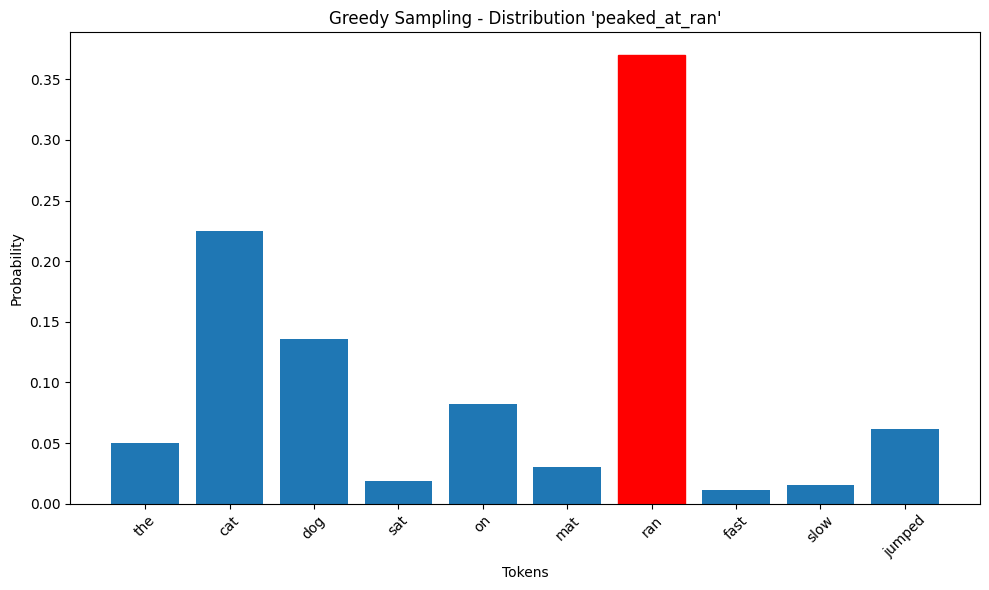

  Distribution 'peaked_at_dog': Selected token 'dog' (ID: 2)


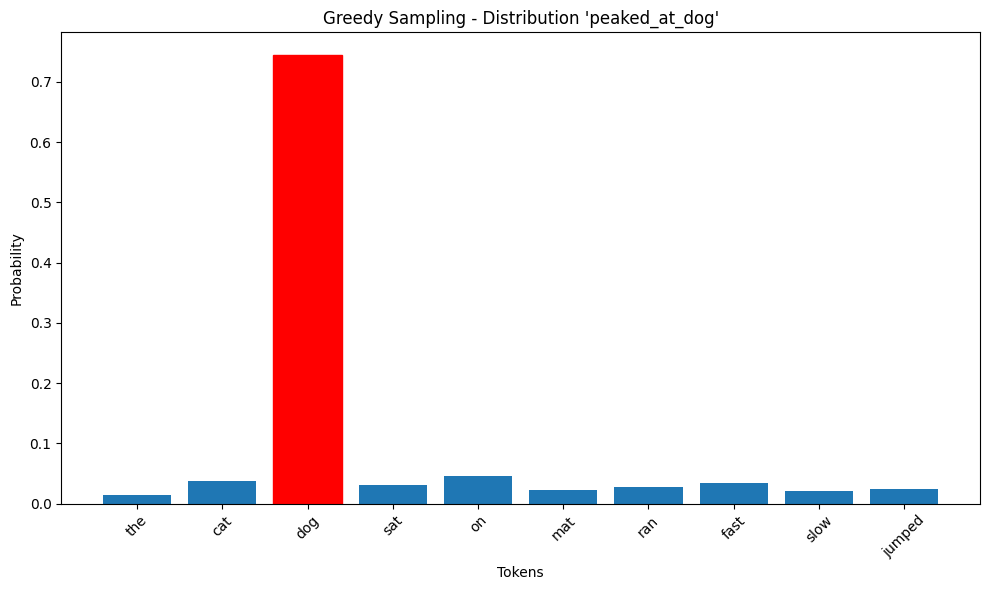

  Distribution 'uniform': Selected token 'jumped' (ID: 9)


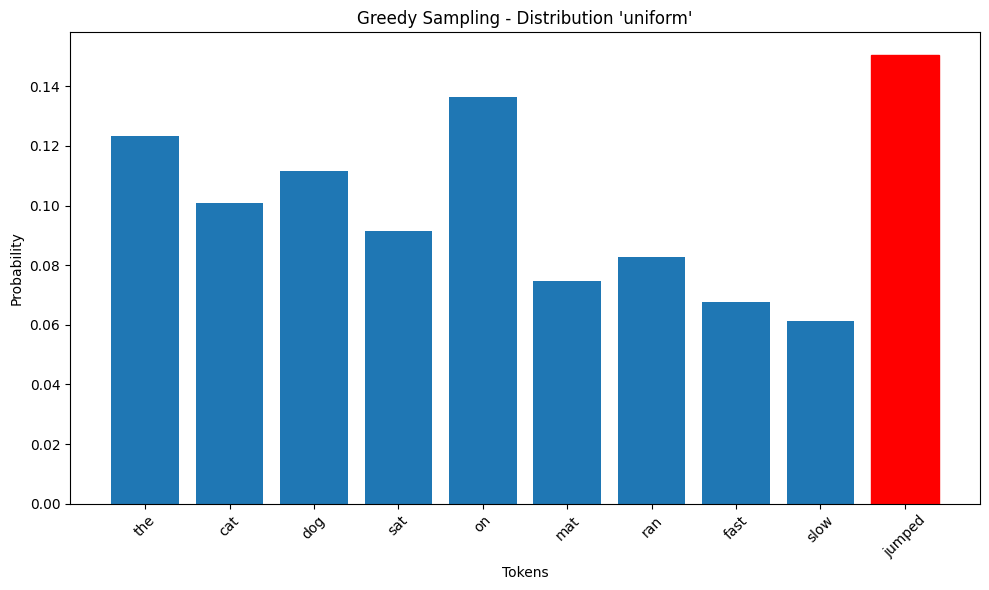

In [5]:
def greedy_sampling(logits: torch.Tensor) -> int:
    """Select the token with the highest probability"""
    return torch.argmax(logits).item()

# Demonstrate greedy sampling with our sample logits
print("Greedy Sampling Results:")
for name, logits in sample_logits.items():
    token_id = greedy_sampling(logits)
    token = id_to_token(token_id)
    print(f"  Distribution '{name}': Selected token '{token}' (ID: {token_id})")
    
    # Visualize the selection
    probs = logits_to_probs(logits)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(vocab, probs.numpy())
    bars[token_id].set_color('red')  # Highlight the selected token
    plt.xlabel('Tokens')
    plt.ylabel('Probability')
    plt.title(f"Greedy Sampling - Distribution '{name}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Greedy Sampling Analysis

As we can see from the results, greedy sampling always selects the token with the highest probability. This makes the generation process deterministic - given the same input, it will always produce the same output.

**Pros of Greedy Sampling:**
- Simple to implement
- Deterministic
- Works well for tasks where there's a clear "right answer" (like arithmetic)

**Cons of Greedy Sampling:**
- Can get stuck in repetition loops
- Produces less diverse and creative text
- Cannot recover from mistakes

Let's see a step-by-step example of how greedy sampling works in a sequence:

1. We have an input sequence "The cat"
2. The model generates logits for the next token
3. We convert logits to probabilities with softmax
4. Select the token with highest probability (e.g., "sat")
5. Add "sat" to our sequence: "The cat sat"
6. Generate logits for the next token after "The cat sat"
7. Again select the highest probability token (e.g., "on")
8. Repeat until we decide to stop

## 2. Temperature Sampling

Temperature sampling introduces randomness by scaling the logits before applying softmax. A higher temperature leads to more uniform probabilities (more random), while a lower temperature makes the distribution more peaked (less random).

Temperature Sampling:
  Temperature 0.5: Selected token 'cat' (ID: 1)
  Temperature 1.0: Selected token 'ran' (ID: 6)
  Temperature 2.0: Selected token 'on' (ID: 4)


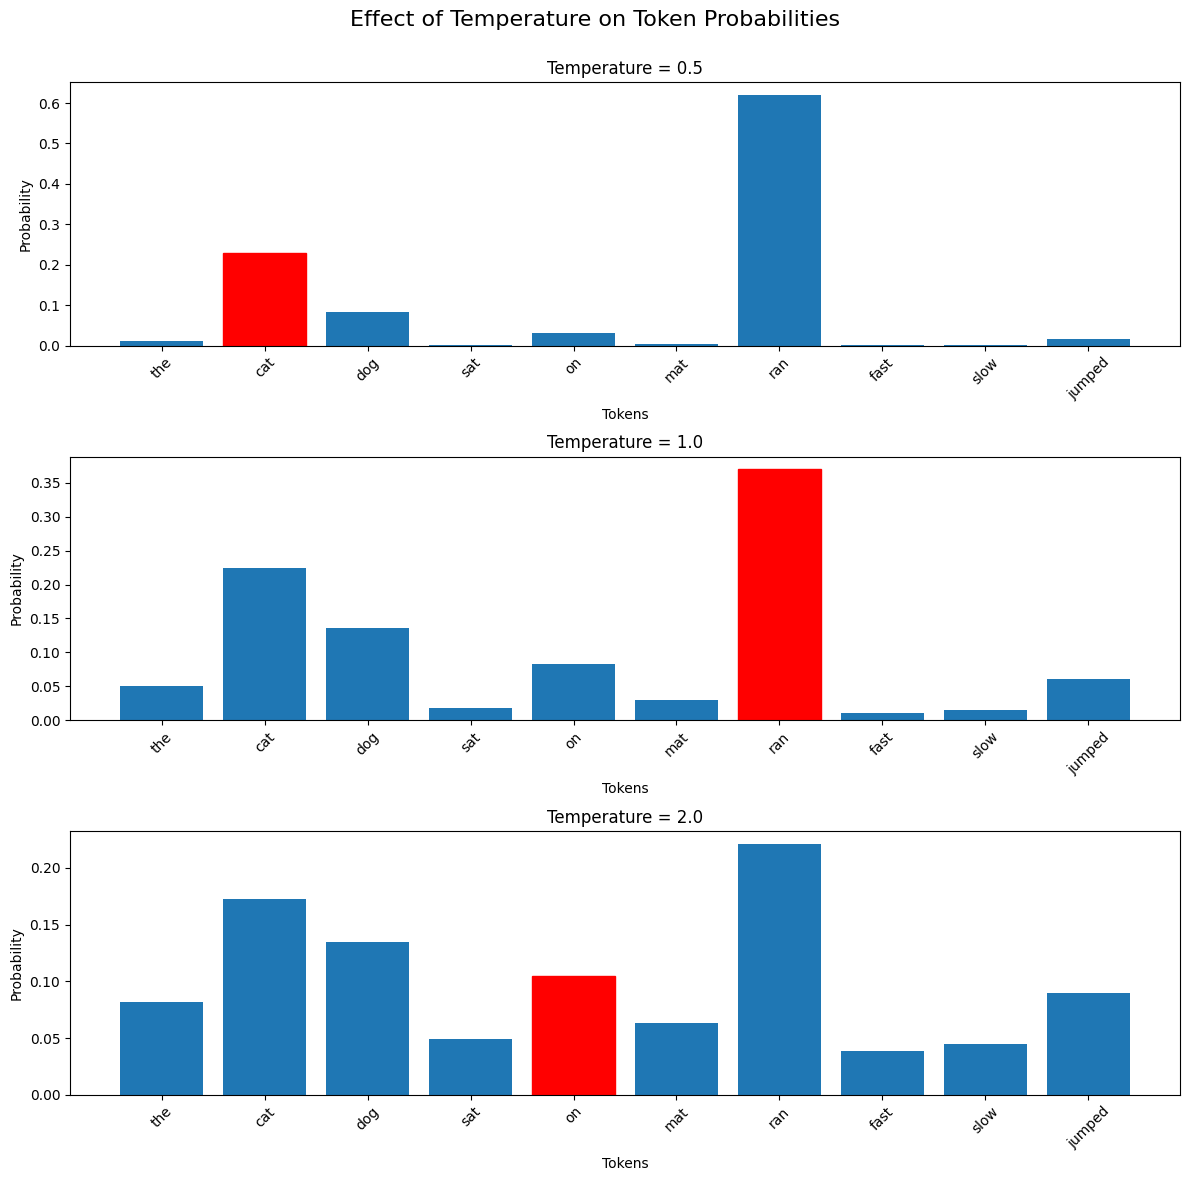


Multiple samples at Temperature 1.0:
  Sample 1: 'cat'
  Sample 2: 'cat'
  Sample 3: 'ran'
  Sample 4: 'the'
  Sample 5: 'mat'
  Sample 6: 'ran'
  Sample 7: 'dog'
  Sample 8: 'ran'
  Sample 9: 'dog'
  Sample 10: 'jumped'


In [6]:
def temperature_sampling(logits: torch.Tensor, temperature: float = 1.0) -> int:
    """Sample from the distribution after applying temperature scaling"""
    if temperature == 0:  # Temperature of 0 is equivalent to greedy sampling
        return greedy_sampling(logits)
    
    # Scale logits by temperature
    scaled_logits = logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Sample from the distribution
    return torch.multinomial(probs, 1).item()

# Demonstrate temperature sampling with various temperatures
temperatures = [0.5, 1.0, 2.0]
logits_to_use = sample_logits["peaked_at_ran"]  # Use one distribution for clarity

# Set up multi-plot figure
fig, axes = plt.subplots(len(temperatures), 1, figsize=(12, 4*len(temperatures)))
fig.suptitle("Effect of Temperature on Token Probabilities", fontsize=16)

print("Temperature Sampling:")
for i, temp in enumerate(temperatures):
    # Scale logits and convert to probabilities
    scaled_logits = logits_to_use / temp
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Sample a token
    token_id = temperature_sampling(logits_to_use, temp)
    token = id_to_token(token_id)
    print(f"  Temperature {temp}: Selected token '{token}' (ID: {token_id})")
    
    # Plot the probability distribution
    ax = axes[i]
    bars = ax.bar(vocab, probs.numpy())
    bars[token_id].set_color('red')  # Highlight the selected token
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Probability')
    ax.set_title(f"Temperature = {temp}")
    ax.set_xticks(range(len(vocab)))
    ax.set_xticklabels(vocab, rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
plt.show()

# Let's demonstrate multiple samples at the same temperature to show randomness
selected_temp = 1.0
num_samples = 10

print(f"\nMultiple samples at Temperature {selected_temp}:")
for i in range(num_samples):
    token_id = temperature_sampling(logits_to_use, selected_temp)
    token = id_to_token(token_id)
    print(f"  Sample {i+1}: '{token}'")

### Temperature Sampling Analysis

Temperature sampling introduces controllable randomness to the generation process. The temperature parameter (T) directly impacts how the model distributes probability mass across the vocabulary:

- **T < 1.0 (Low temperature)**: Makes the distribution more peaked, emphasizing high-probability tokens. As T approaches 0, it becomes equivalent to greedy sampling.
- **T = 1.0**: No modification to the original distribution.
- **T > 1.0 (High temperature)**: Makes the distribution more uniform, giving lower-probability tokens a better chance of being selected.

The formula for temperature scaling is:

$$p_i = \frac{\exp(z_i/T)}{\sum_j \exp(z_j/T)}$$

Where:
- $z_i$ is the logit for token $i$
- $T$ is the temperature
- $p_i$ is the resulting probability for token $i$

**Pros of Temperature Sampling:**
- Provides a simple way to control randomness/creativity
- Can produce more diverse outputs than greedy sampling
- Preserves the relative ordering of token probabilities

**Cons of Temperature Sampling:**
- At high temperatures, can generate low-quality or nonsensical text
- At low temperatures, can still suffer from repetition issues
- Difficult to find the "right" temperature for every generation scenario

## 3. Top-K Sampling

Top-K sampling restricts token selection to only the K most likely candidates. This prevents the model from selecting tokens with very low probabilities.

Top-K Sampling:
  k=3: Selected token 'the' (ID: 0)
  k=5: Selected token 'on' (ID: 4)
  k=8: Selected token 'the' (ID: 0)


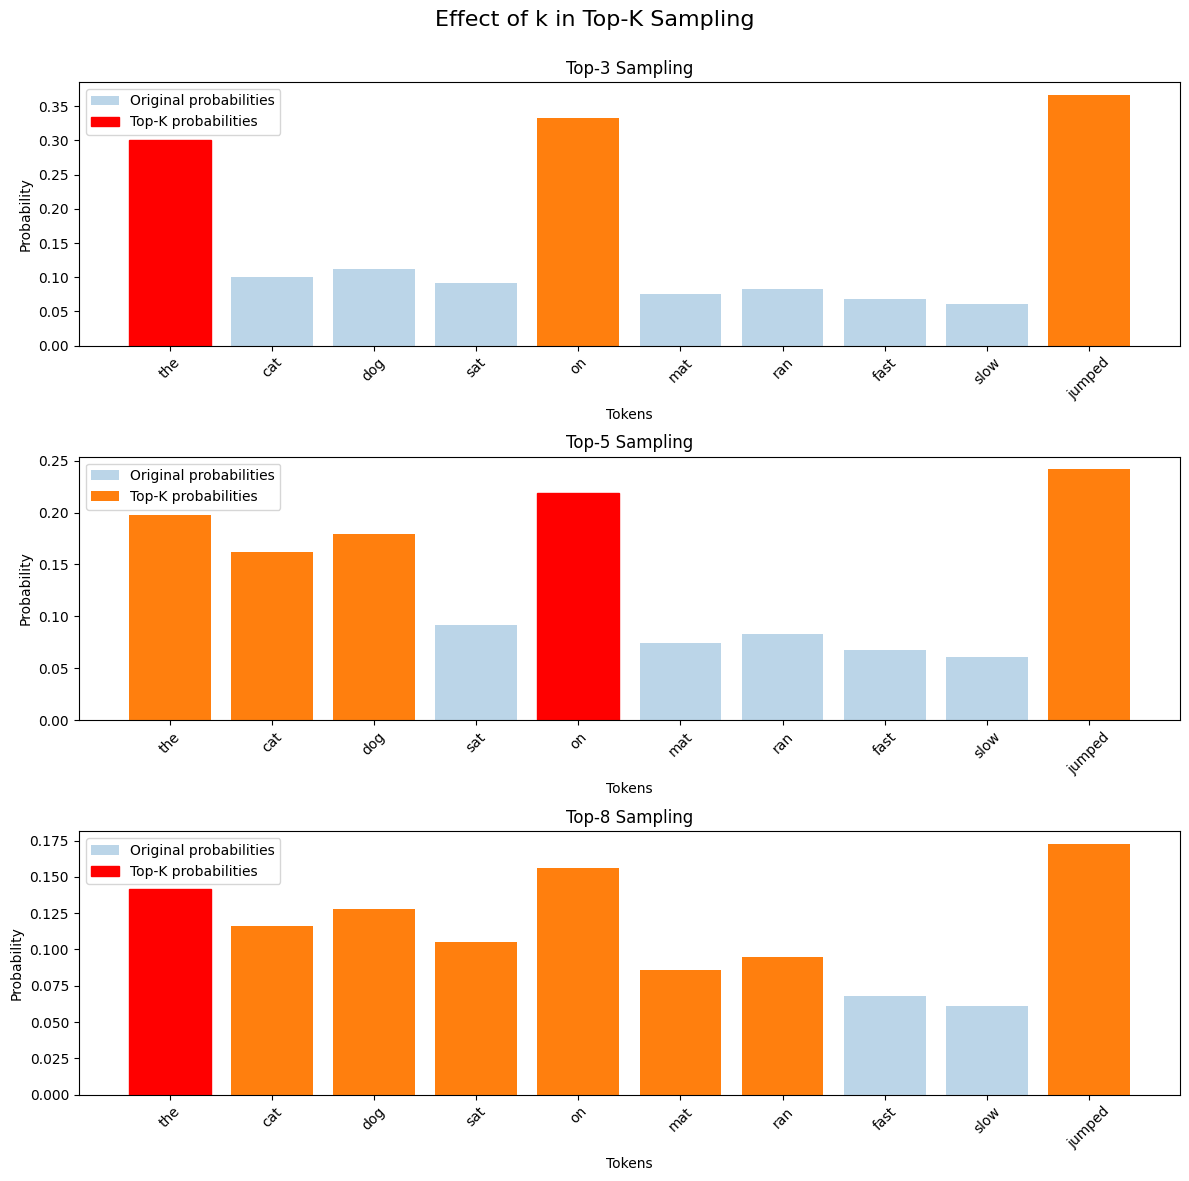


Multiple samples with Top-5:
  Sample 1: 'cat'
  Sample 2: 'the'
  Sample 3: 'cat'
  Sample 4: 'the'
  Sample 5: 'dog'
  Sample 6: 'cat'
  Sample 7: 'on'
  Sample 8: 'dog'
  Sample 9: 'on'
  Sample 10: 'on'


In [7]:
def top_k_sampling(logits: torch.Tensor, k: int = 5, temperature: float = 1.0) -> int:
    """Sample from the k most likely tokens"""
    # Apply temperature scaling first
    scaled_logits = logits / temperature
    
    # Find the top-k tokens
    top_k_logits, top_k_indices = torch.topk(scaled_logits, k)
    
    # Convert to probabilities
    top_k_probs = F.softmax(top_k_logits, dim=-1)
    
    # Sample from the top-k distribution
    sampled_index = torch.multinomial(top_k_probs, 1).item()
    
    # Map back to the original vocabulary index
    return top_k_indices[sampled_index].item()

# Demonstrate top-k sampling with various k values
k_values = [3, 5, 8]
logits_to_use = sample_logits["uniform"]  # Use more uniform distribution to see effect

# Initialize plot
fig, axes = plt.subplots(len(k_values), 1, figsize=(12, 4*len(k_values)))
fig.suptitle("Effect of k in Top-K Sampling", fontsize=16)

print("Top-K Sampling:")
for i, k in enumerate(k_values):
    # Get original probabilities
    original_probs = F.softmax(logits_to_use, dim=-1)
    
    # Find top-k tokens and their probabilities
    top_k_values, top_k_indices = torch.topk(logits_to_use, k)
    top_k_probs = F.softmax(top_k_values, dim=-1)
    
    # Sample token
    token_id = top_k_sampling(logits_to_use, k)
    token = id_to_token(token_id)
    print(f"  k={k}: Selected token '{token}' (ID: {token_id})")
    
    # Create new distribution for visualization (all mass on top-k tokens)
    modified_probs = torch.zeros_like(logits_to_use)
    for j, idx in enumerate(top_k_indices):
        modified_probs[idx] = top_k_probs[j]
    
    # Plot
    ax = axes[i]
    
    # Plot original distribution (transparent)
    ax.bar(vocab, original_probs.numpy(), alpha=0.3, label='Original probabilities')
    
    # Plot top-k distribution
    bars = ax.bar(vocab, modified_probs.numpy(), label='Top-K probabilities')
    
    # Highlight selected token
    if token_id in top_k_indices:
        bars[token_id].set_color('red')
    
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Probability')
    ax.set_title(f"Top-{k} Sampling")
    ax.set_xticks(range(len(vocab)))
    ax.set_xticklabels(vocab, rotation=45)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
plt.show()

# Let's demonstrate multiple samples with top-k to show variation
selected_k = 5
num_samples = 10

print(f"\nMultiple samples with Top-{selected_k}:")
for i in range(num_samples):
    token_id = top_k_sampling(logits_to_use, selected_k)
    token = id_to_token(token_id)
    print(f"  Sample {i+1}: '{token}'")

### Top-K Sampling Analysis

Top-K sampling addresses a key limitation of temperature sampling: it prevents the model from sampling very unlikely tokens. The algorithm works as follows:

1. Identify the K tokens with the highest probabilities
2. Set the probabilities of all other tokens to zero
3. Renormalize the probability distribution across the K tokens
4. Sample from this truncated distribution

This approach ensures that the model only considers the K most likely continuations, which can prevent nonsensical or out-of-distribution outputs.

**Pros of Top-K Sampling:**
- Prevents selection of very low probability tokens
- Generally produces more coherent text than high-temperature sampling
- Simple to implement and computationally efficient

**Cons of Top-K Sampling:**
- Fixed K is not optimal for all contexts
- In highly-peaked distributions, K might be too restrictive
- In flat distributions, K might allow too many low-quality options

The optimal value of K often depends on the specific use case and model. Common values range from 10 to 50 in practice.

## 4. Top-p (Nucleus) Sampling

Top-p sampling (also called nucleus sampling) dynamically selects the smallest set of tokens whose cumulative probability exceeds a threshold p. This adapts to the confidence of the model.


Top-p Sampling on peaked_at_ran distribution:
  p=0.5: Selected token 'ran' (ID: 6), Nucleus size: 1
  p=0.7: Selected token 'ran' (ID: 6), Nucleus size: 2
  p=0.9: Selected token 'on' (ID: 4), Nucleus size: 5


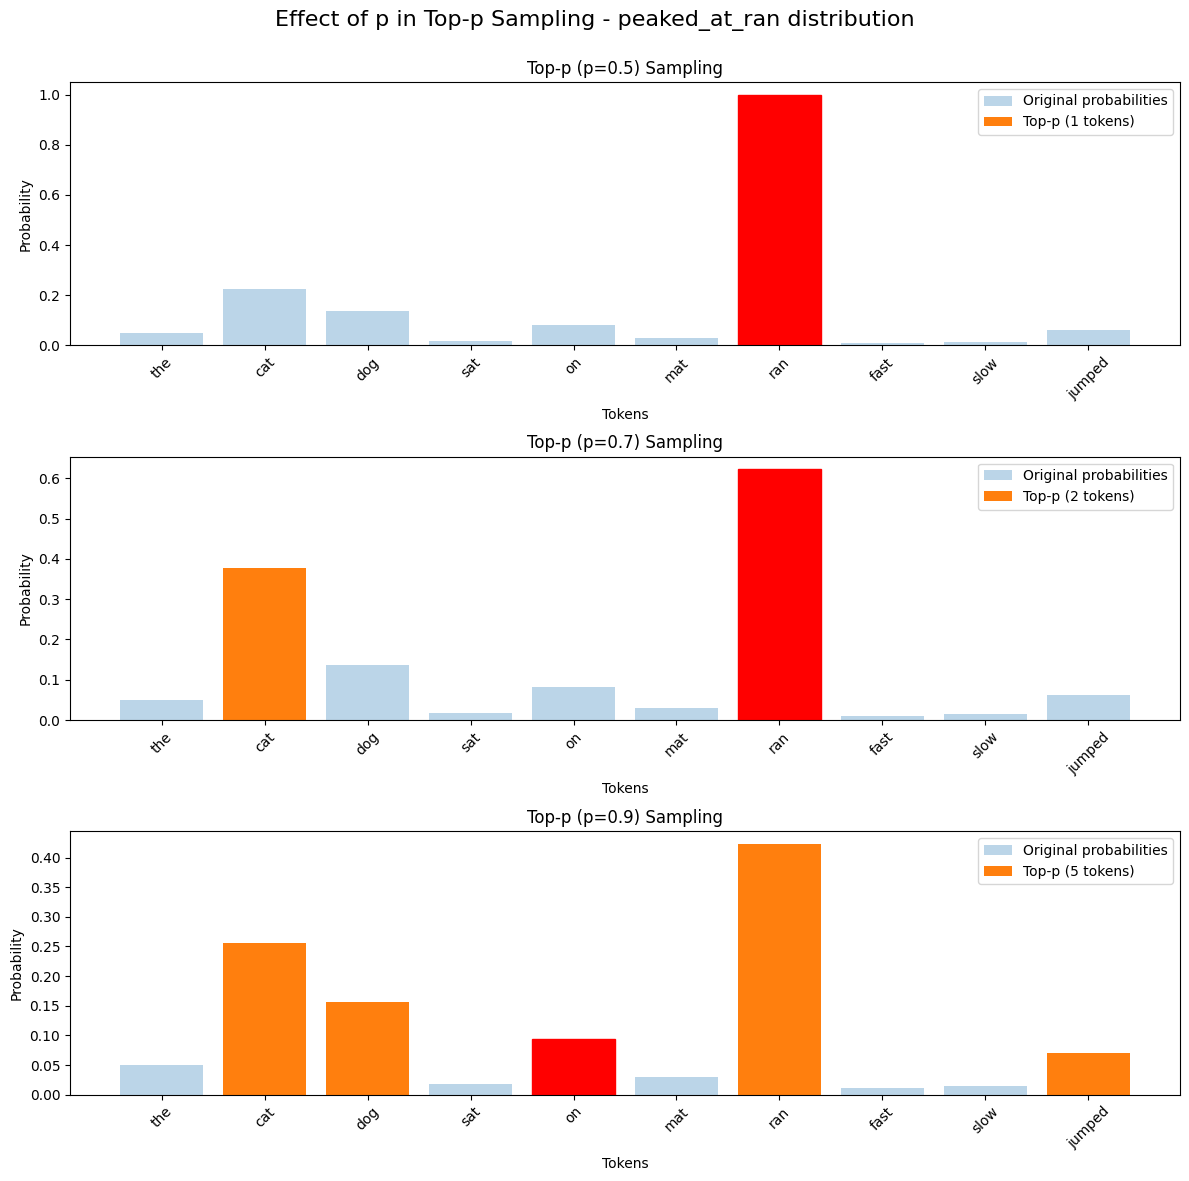


Top-p Sampling on uniform distribution:
  p=0.5: Selected token 'on' (ID: 4), Nucleus size: 3
  p=0.7: Selected token 'cat' (ID: 1), Nucleus size: 5
  p=0.9: Selected token 'jumped' (ID: 9), Nucleus size: 8


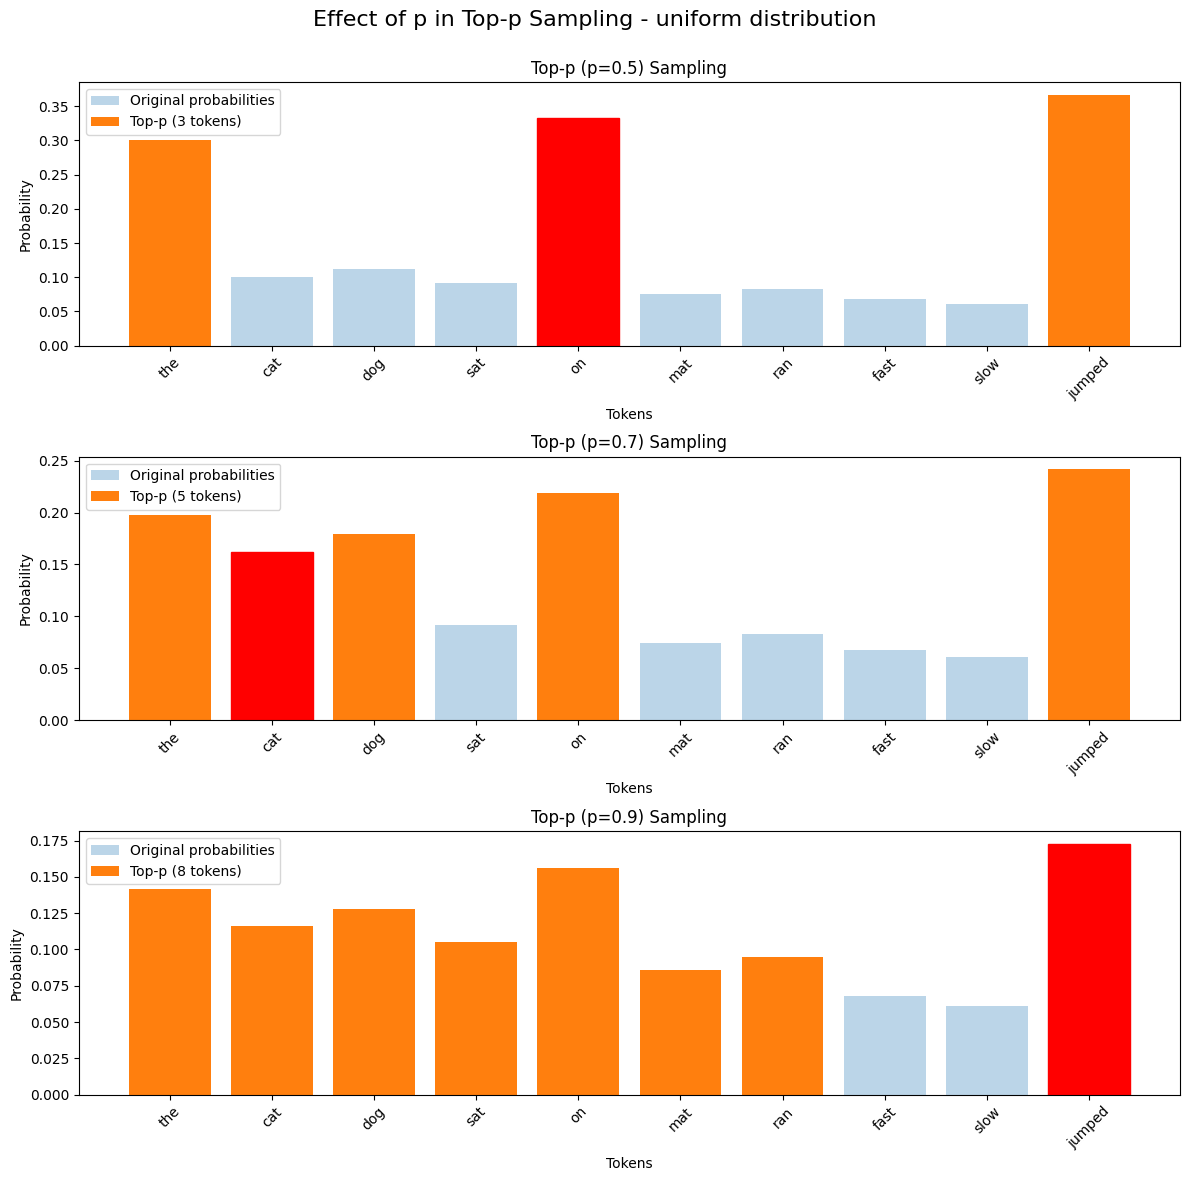


Multiple samples with Top-p (p=0.9):
  Sample 1: 'dog'
  Sample 2: 'dog'
  Sample 3: 'jumped'
  Sample 4: 'ran'
  Sample 5: 'mat'
  Sample 6: 'sat'
  Sample 7: 'dog'
  Sample 8: 'on'
  Sample 9: 'sat'
  Sample 10: 'sat'


In [8]:
def top_p_sampling(logits: torch.Tensor, p: float = 0.9, temperature: float = 1.0) -> int:
    """Sample from the smallest set of tokens with cumulative probability >= p"""
    # Apply temperature scaling
    scaled_logits = logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Sort probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    
    # Calculate cumulative probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # Find tokens within the nucleus (where cumulative prob >= p)
    nucleus_indices = cumulative_probs <= p
    nucleus_indices[0] = True  # Always include the most likely token
    
    # Select the tokens within the nucleus
    nucleus_probs = sorted_probs[nucleus_indices]
    nucleus_indices = sorted_indices[nucleus_indices]
    
    # Sample from the nucleus
    sampled_index = torch.multinomial(nucleus_probs, 1).item()
    
    # Map back to the original vocabulary index
    return nucleus_indices[sampled_index].item()

# Demonstrate top-p sampling with various p values
p_values = [0.5, 0.7, 0.9]

# Test on two different distributions
distributions = ["peaked_at_ran", "uniform"]

for dist_name in distributions:
    logits_to_use = sample_logits[dist_name]
    
    # Initialize plot
    fig, axes = plt.subplots(len(p_values), 1, figsize=(12, 4*len(p_values)))
    fig.suptitle(f"Effect of p in Top-p Sampling - {dist_name} distribution", fontsize=16)
    
    print(f"\nTop-p Sampling on {dist_name} distribution:")
    for i, p in enumerate(p_values):
        # Get original probabilities
        probs = F.softmax(logits_to_use, dim=-1)
        
        # Sort probabilities for visualization
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        nucleus_mask = cumulative_probs <= p
        nucleus_mask[0] = True  # Always include the most likely token
        
        # Count tokens in the nucleus
        nucleus_size = nucleus_mask.sum().item()
        
        # Sample token
        token_id = top_p_sampling(logits_to_use, p)
        token = id_to_token(token_id)
        print(f"  p={p}: Selected token '{token}' (ID: {token_id}), Nucleus size: {nucleus_size}")
        
        # Create modified distribution for visualization
        modified_probs = torch.zeros_like(probs)
        for j, idx in enumerate(sorted_indices):
            if j < nucleus_size:
                modified_probs[idx] = probs[idx]
        
        # Normalize the modified distribution
        if modified_probs.sum() > 0:
            modified_probs = modified_probs / modified_probs.sum()
        
        # Plot
        ax = axes[i]
        
        # Plot original distribution (transparent)
        ax.bar(vocab, probs.numpy(), alpha=0.3, label='Original probabilities')
        
        # Plot nucleus distribution
        bars = ax.bar(vocab, modified_probs.numpy(), label=f'Top-p ({nucleus_size} tokens)')
        
        # Highlight selected token
        bars[token_id].set_color('red')
        
        ax.set_xlabel('Tokens')
        ax.set_ylabel('Probability')
        ax.set_title(f"Top-p (p={p}) Sampling")
        ax.set_xticks(range(len(vocab)))
        ax.set_xticklabels(vocab, rotation=45)
        ax.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
    plt.show()

# Let's demonstrate multiple samples with top-p to show variation
selected_p = 0.9
num_samples = 10
logits_to_use = sample_logits["uniform"]

print(f"\nMultiple samples with Top-p (p={selected_p}):")
for i in range(num_samples):
    token_id = top_p_sampling(logits_to_use, selected_p)
    token = id_to_token(token_id)
    print(f"  Sample {i+1}: '{token}'")

### Top-p (Nucleus) Sampling Analysis

Top-p sampling, introduced in the paper "The Curious Case of Neural Text Degeneration" (Holtzman et al., 2019), adapts to the confidence of the model. It selects the smallest set of tokens whose cumulative probability exceeds a threshold p (the "nucleus").

The algorithm works as follows:

1. Sort tokens by probability in descending order
2. Calculate cumulative probabilities
3. Select the smallest set of tokens such that their cumulative probability e p
4. Renormalize the probability distribution across these tokens
5. Sample from this truncated distribution

Notice how the size of the nucleus changes based on the distribution:
- For peaked distributions, top-p selects fewer tokens
- For flat distributions, top-p selects more tokens

This adaptive behavior is the key advantage of top-p over top-k sampling.

**Pros of Top-p Sampling:**
- Adapts to the confidence of the model in different contexts
- Works well across various types of distributions
- Often produces more natural-sounding text than fixed top-k

**Cons of Top-p Sampling:**
- Slightly more complex to implement than top-k
- May still include low-probability tokens in very flat distributions
- Finding the optimal p value can require tuning

Common values for p range from 0.9 to 0.95 in practice. Many state-of-the-art systems use top-p sampling, sometimes in combination with temperature sampling or top-k.

## 5. Beam Search

Beam search maintains multiple candidate sequences (the beam) and selects the one with the highest cumulative probability. This is useful for finding high-probability sequences.

In [9]:
class BeamSearchState:
    def __init__(self, sequence, log_prob):
        self.sequence = sequence  # List of token IDs
        self.log_prob = log_prob  # Log probability of the sequence

def beam_search_step(model, current_beams, beam_width, max_seq_len):
    """Perform one step of beam search."""
    all_candidates = []
    
    # Expand each beam
    for beam in current_beams:
        # If beam has reached max length or end token, keep as is
        if len(beam.sequence) >= max_seq_len:
            all_candidates.append(beam)
            continue
        
        # For simulation, we'll just use pre-computed logits
        # In reality, we would run the model to get next-token logits
        # logits = model(torch.tensor([beam.sequence]))[0, -1, :]
        
        # For demo, we'll use a random distribution
        logits_name = list(sample_logits.keys())[len(beam.sequence) % len(sample_logits)]
        logits = sample_logits[logits_name]
        
        log_probs = F.log_softmax(logits, dim=-1)
        
        # Get top-k next tokens
        top_log_probs, top_indices = torch.topk(log_probs, beam_width)
        
        # Create a new candidate beam for each top token
        for i in range(beam_width):
            next_token = top_indices[i].item()
            next_log_prob = top_log_probs[i].item()
            
            new_sequence = beam.sequence + [next_token]
            new_log_prob = beam.log_prob + next_log_prob
            
            all_candidates.append(BeamSearchState(new_sequence, new_log_prob))
    
    # Sort candidates by log probability and keep top beam_width
    all_candidates.sort(key=lambda x: x.log_prob, reverse=True)
    return all_candidates[:beam_width]

def run_beam_search(model, initial_sequence, beam_width, max_seq_len):
    """Run beam search to generate a sequence"""
    # Initialize beam with the initial sequence
    current_beams = [BeamSearchState(initial_sequence, 0.0)]
    
    # Run beam search for max_seq_len steps
    for _ in range(max_seq_len):
        current_beams = beam_search_step(model, current_beams, beam_width, max_seq_len)
    
    # Return the highest probability sequence
    return current_beams[0].sequence

# Demonstrate beam search
beam_widths = [1, 2, 3]
initial_sequence = [0]  # Start with token "the" (ID: 0)
max_seq_len = 5

print("Beam Search Results:")
for beam_width in beam_widths:
    # Use None as model since we're using pre-computed logits
    output_sequence = run_beam_search(None, initial_sequence, beam_width, max_seq_len)
    output_tokens = [id_to_token(idx) for idx in output_sequence]
    
    print(f"  Beam width {beam_width}: {' '.join(output_tokens)}")
    
    # Let's visualize the beam search process for beam_width=2
    if beam_width == 2:
        # Re-run with visualization
        current_beams = [BeamSearchState(initial_sequence, 0.0)]
        print("\nStep-by-step Beam Search Process (beam_width=2):")
        
        for step in range(max_seq_len):
            print(f"\nStep {step+1}:")
            print("  Current beams:")
            for i, beam in enumerate(current_beams):
                beam_tokens = [id_to_token(idx) for idx in beam.sequence]
                print(f"    Beam {i+1}: {' '.join(beam_tokens)} (log prob: {beam.log_prob:.2f})")
            
            current_beams = beam_search_step(None, current_beams, beam_width, max_seq_len)
            
            print("  New beams after expansion:")
            for i, beam in enumerate(current_beams):
                beam_tokens = [id_to_token(idx) for idx in beam.sequence]
                print(f"    Beam {i+1}: {' '.join(beam_tokens)} (log prob: {beam.log_prob:.2f})")

Beam Search Results:
  Beam width 1: the dog jumped ran dog
  Beam width 2: the dog jumped ran dog

Step-by-step Beam Search Process (beam_width=2):

Step 1:
  Current beams:
    Beam 1: the (log prob: 0.00)
  New beams after expansion:
    Beam 1: the dog (log prob: -0.29)
    Beam 2: the on (log prob: -3.09)

Step 2:
  Current beams:
    Beam 1: the dog (log prob: -0.29)
    Beam 2: the on (log prob: -3.09)
  New beams after expansion:
    Beam 1: the dog jumped (log prob: -2.19)
    Beam 2: the dog on (log prob: -2.29)

Step 3:
  Current beams:
    Beam 1: the dog jumped (log prob: -2.19)
    Beam 2: the dog on (log prob: -2.29)
  New beams after expansion:
    Beam 1: the dog jumped ran (log prob: -3.18)
    Beam 2: the dog on ran (log prob: -3.28)

Step 4:
  Current beams:
    Beam 1: the dog jumped ran (log prob: -3.18)
    Beam 2: the dog on ran (log prob: -3.28)
  New beams after expansion:
    Beam 1: the dog jumped ran dog (log prob: -3.48)
    Beam 2: the dog on ran dog (log

### Beam Search Analysis

Beam search is a breadth-first search algorithm that explores multiple possible continuation paths simultaneously. Unlike the sampling methods we've seen so far, beam search is designed to find the most likely sequence overall, not just at each step.

The algorithm works as follows:

1. Start with an initial sequence and maintain a list of the top-B sequences (where B is the beam width)
2. For each sequence in the beam, compute the next-token probabilities
3. For each sequence, consider all possible next tokens
4. From these B�(vocab size) possible continuations, select the top-B sequences with the highest cumulative log-probability
5. Repeat steps 2-4 until a stopping criterion is met
6. Return the highest-scoring complete sequence

Note that beam search uses log-probabilities to prevent numerical underflow when multiplying many probabilities together. The cumulative score for a sequence is the sum of the log-probabilities of each token.

**Pros of Beam Search:**
- Often finds sequences with higher overall probability
- Helpful for tasks requiring precision, like translation or summarization
- Can compare multiple high-scoring candidate sequences

**Cons of Beam Search:**
- Computationally expensive (scales with beam width)
- Tends to produce generic, "safe" text
- Can get stuck in repetition loops
- Not suitable for creative text generation

Special note: Beam search with beam width B=1 is equivalent to greedy search. As the beam width increases, beam search explores more alternative continuations, potentially finding higher-probability sequences.

## 6. Repetition Penalty

Repetition penalty discourages the model from generating the same tokens multiple times by penalizing tokens that have already appeared in the generated text.

Example sequence: the cat cat dog cat

Repetition Penalty Sampling:
  Penalty 1.0: Selected token 'dog' (ID: 2)
    Penalized tokens: ['the', 'cat', 'dog']
  Penalty 1.5: Selected token 'the' (ID: 0)
    Penalized tokens: ['the', 'cat', 'dog']
  Penalty 3.0: Selected token 'dog' (ID: 2)
    Penalized tokens: ['the', 'cat', 'dog']


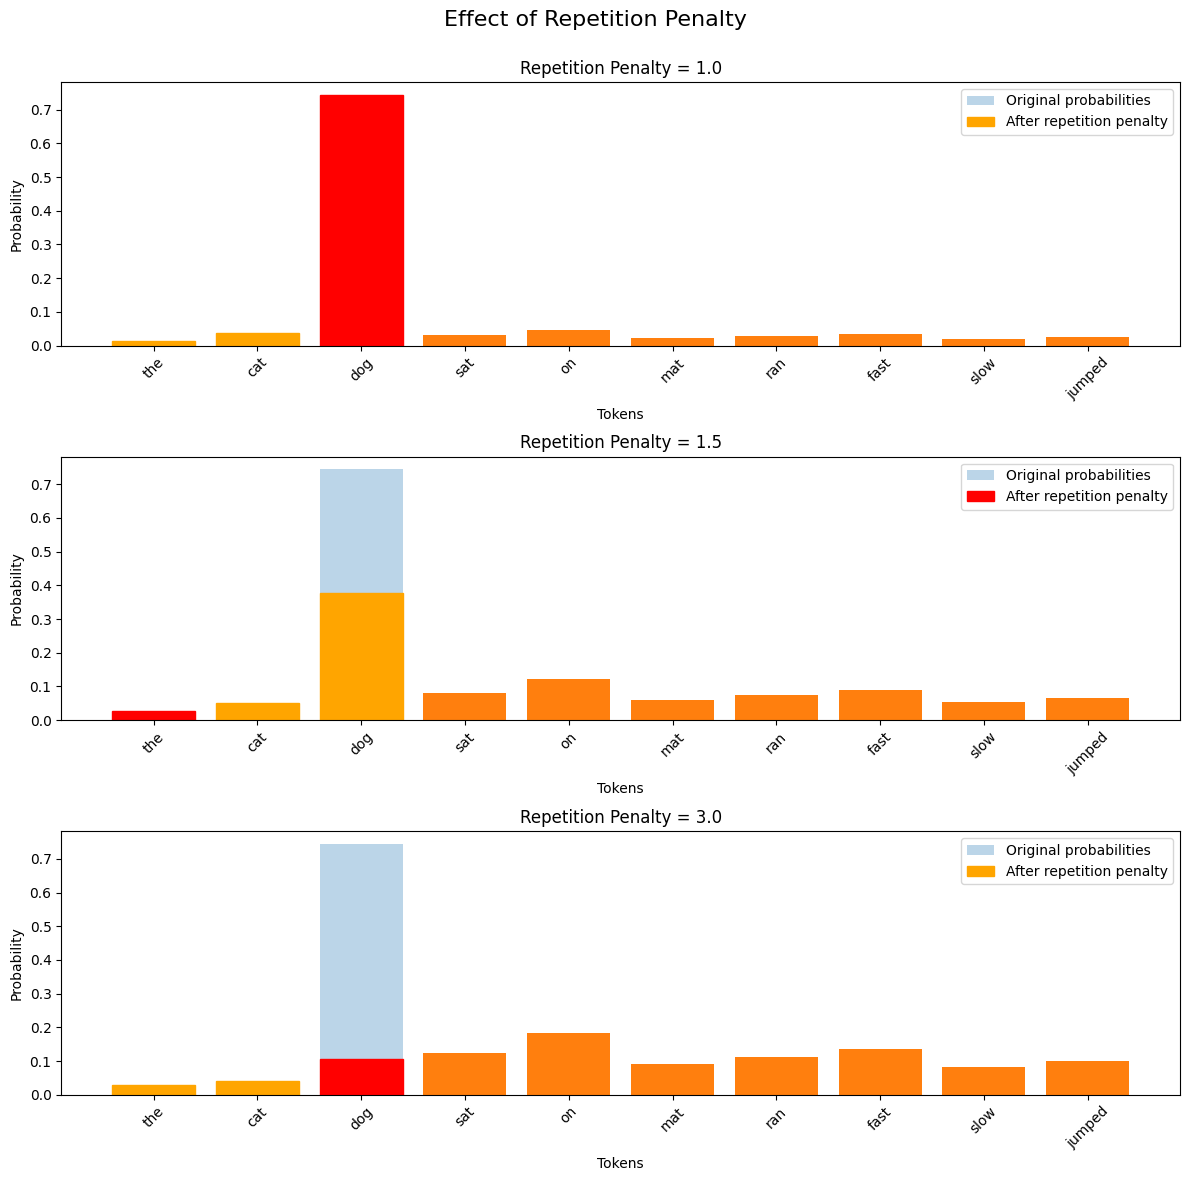


Generated sequences with different repetition penalties:
  Penalty 1.0: the cat dog dog jumped dog the ran mat on
  Penalty 1.5: the cat dog jumped ran ran sat the dog mat
  Penalty 2.5: the jumped dog ran cat dog on sat cat ran


In [10]:
def apply_repetition_penalty(logits: torch.Tensor, generated_tokens: List[int], penalty: float = 1.2) -> torch.Tensor:
    """Apply repetition penalty to logits based on tokens that have already been generated"""
    # Make a copy of the logits to avoid modifying the original
    penalized_logits = logits.clone()
    
    # Apply penalty to tokens that have already been generated
    for token_id in set(generated_tokens):  # Use set to handle each token once
        if penalized_logits[token_id] > 0:  # If logit is positive
            penalized_logits[token_id] /= penalty
        else:  # If logit is negative
            penalized_logits[token_id] *= penalty
    
    return penalized_logits

# Let's demonstrate repetition penalty on a token sequence
def sample_with_repetition_penalty(logits: torch.Tensor, generated_tokens: List[int], 
                                  penalty: float = 1.2, temperature: float = 1.0) -> int:
    """Sample from the distribution after applying repetition penalty"""
    # Apply repetition penalty first
    penalized_logits = apply_repetition_penalty(logits, generated_tokens, penalty)
    
    # Then apply temperature
    scaled_logits = penalized_logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Sample from the distribution
    return torch.multinomial(probs, 1).item()

# Simulate a sequence with repetitive tokens to show the effect of repetition penalty
example_sequence = [0, 1, 1, 2, 1]  # "the cat cat dog cat"
print(f"Example sequence: {' '.join([id_to_token(idx) for idx in example_sequence])}")

penalty_values = [1.0, 1.5, 3.0]  # 1.0 = no penalty
logits_to_use = sample_logits["peaked_at_dog"]  # Distribution peaked at 'dog' (token_id: 2)

# Initialize plot
fig, axes = plt.subplots(len(penalty_values), 1, figsize=(12, 4*len(penalty_values)))
fig.suptitle("Effect of Repetition Penalty", fontsize=16)

print("\nRepetition Penalty Sampling:")
for i, penalty in enumerate(penalty_values):
    # Apply repetition penalty
    penalized_logits = apply_repetition_penalty(logits_to_use, example_sequence, penalty)
    
    # Convert to probabilities
    original_probs = F.softmax(logits_to_use, dim=-1)
    penalized_probs = F.softmax(penalized_logits, dim=-1)
    
    # Sample token
    token_id = sample_with_repetition_penalty(logits_to_use, example_sequence, penalty)
    token = id_to_token(token_id)
    print(f"  Penalty {penalty}: Selected token '{token}' (ID: {token_id})")
    
    # Find tokens that were penalized (those in the sequence)
    penalized_tokens = list(set(example_sequence))
    print(f"    Penalized tokens: {[id_to_token(idx) for idx in penalized_tokens]}")
    
    # Calculate change in probability for each token
    prob_change = penalized_probs - original_probs
    
    # Plot
    ax = axes[i]
    
    # Plot original probabilities
    ax.bar(vocab, original_probs.numpy(), alpha=0.3, label='Original probabilities')
    
    # Plot penalized probabilities
    bars = ax.bar(vocab, penalized_probs.numpy(), label='After repetition penalty')
    
    # Highlight penalized tokens
    for idx in penalized_tokens:
        bars[idx].set_color('orange')
    
    # Highlight selected token
    bars[token_id].set_color('red')
    
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Probability')
    ax.set_title(f"Repetition Penalty = {penalty}")
    ax.set_xticks(range(len(vocab)))
    ax.set_xticklabels(vocab, rotation=45)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
plt.show()

# Let's simulate a sequence generation with repetition penalty to show its effect
def generate_sequence(logits_dict, max_length=10, penalty=1.5, temperature=1.0):
    sequence = [0]  # Start with "the"
    
    for i in range(max_length - 1):
        # In reality, we would run the model to get logits
        # For simulation, alternate between our sample distributions
        logits_name = list(logits_dict.keys())[i % len(logits_dict)]
        logits = logits_dict[logits_name]
        
        # Apply repetition penalty and sample
        token_id = sample_with_repetition_penalty(logits, sequence, penalty, temperature)
        sequence.append(token_id)
    
    return sequence

penalty_values = [1.0, 1.5, 2.5]  # 1.0 = no penalty
print("\nGenerated sequences with different repetition penalties:")
for penalty in penalty_values:
    sequence = generate_sequence(sample_logits, penalty=penalty)
    tokens = [id_to_token(idx) for idx in sequence]
    print(f"  Penalty {penalty}: {' '.join(tokens)}")

### Repetition Penalty Analysis

Repetition penalty is a simple but effective technique to prevent the model from generating repetitive text. It works by reducing the probability of tokens that have already appeared in the generated sequence.

The algorithm works as follows:

1. Identify the set of tokens that have already been generated
2. For each such token:
   - If its logit is positive, divide it by the penalty factor
   - If its logit is negative, multiply it by the penalty factor
3. Apply other sampling methods (e.g., temperature, top-k, top-p) on these adjusted logits

The effect of the penalty is that it directly reduces the likelihood of generating the same token multiple times, which leads to more diverse text.

The formula for repetition penalty is:

$$\text{If } z_i > 0:\quad z_i' = \frac{z_i}{\text{penalty}}$$
$$\text{If } z_i \leq 0:\quad z_i' = z_i \times \text{penalty}$$

Where:
- $z_i$ is the logit for token $i$
- $z_i'$ is the adjusted logit
- $\text{penalty}$ is the repetition penalty factor (typically > 1.0)

**Pros of Repetition Penalty:**
- Simple and effective way to reduce repetition
- Can be combined with any other sampling method
- Computationally inexpensive

**Cons of Repetition Penalty:**
- Too high a penalty can prevent intentional repetition (like "very, very")
- May not distinguish between good and bad repetition
- Doesn't capture longer-range dependencies or patterns

Common values for repetition penalty range from 1.0 (no penalty) to 2.0, with 1.2-1.5 being typical choices.

## Combining Sampling Methods

In practice, these sampling methods are often combined to get the best results. A common approach is to use temperature scaling with top-p or top-k sampling, and apply a repetition penalty.

In [11]:
def combined_sampling(logits: torch.Tensor, generated_tokens: List[int] = None,
                      temperature: float = 1.0, top_k: int = None, top_p: float = None,
                      repetition_penalty: float = 1.0) -> int:
    """Combined sampling with multiple methods"""
    # Start with original logits
    working_logits = logits.clone()
    
    # Apply repetition penalty if applicable
    if generated_tokens is not None and repetition_penalty > 1.0:
        working_logits = apply_repetition_penalty(working_logits, generated_tokens, repetition_penalty)
    
    # Apply temperature scaling
    if temperature != 1.0:
        working_logits = working_logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(working_logits, dim=-1)
    
    # Apply top-k if specified
    if top_k is not None:
        # Set probabilities outside top-k to zero
        top_k_probs, top_k_indices = torch.topk(probs, min(top_k, len(probs)))
        new_probs = torch.zeros_like(probs)
        new_probs[top_k_indices] = top_k_probs
        probs = new_probs
        
        # Renormalize if needed
        if probs.sum() > 0:
            probs = probs / probs.sum()
    
    # Apply top-p if specified
    if top_p is not None and top_p < 1.0:
        # Sort probabilities
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        
        # Calculate cumulative probabilities
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Find cutoff point for nucleus
        nucleus_indices = cumulative_probs <= top_p
        nucleus_indices[0] = True  # Always include the most likely token
        
        # Set probabilities outside nucleus to zero
        sorted_probs[~nucleus_indices] = 0
        
        # Rearrange back to original order
        new_probs = torch.zeros_like(probs)
        for i, idx in enumerate(sorted_indices):
            new_probs[idx] = sorted_probs[i]
        probs = new_probs
        
        # Renormalize if needed
        if probs.sum() > 0:
            probs = probs / probs.sum()
    
    # If all probabilities are zero (can happen in extreme cases), back off to uniform
    if probs.sum() == 0:
        probs = torch.ones_like(probs) / len(probs)
    
    # Sample from the final distribution
    return torch.multinomial(probs, 1).item()

# Demonstrate a typical combined approach: temperature + top-p + repetition penalty
logits_to_use = sample_logits["peaked_at_dog"]
example_sequence = [0, 1, 2, 2]  # "the cat dog dog"

# Parameters for combined sampling
temp = 0.8
p = 0.9
rep_penalty = 1.5

print("Combined Sampling Example:")
print(f"Original sequence: {' '.join([id_to_token(idx) for idx in example_sequence])}")
print(f"Parameters: temperature={temp}, top_p={p}, repetition_penalty={rep_penalty}")

# Generate 5 next tokens with combined sampling
sequence = example_sequence.copy()
generated = []

for i in range(5):
    next_token_id = combined_sampling(logits_to_use, sequence, 
                                     temperature=temp, top_p=p, repetition_penalty=rep_penalty)
    sequence.append(next_token_id)
    generated.append(id_to_token(next_token_id))

print(f"Generated next tokens: {' '.join(generated)}")
print(f"Full sequence: {' '.join([id_to_token(idx) for idx in sequence])}")

Combined Sampling Example:
Original sequence: the cat dog dog
Parameters: temperature=0.8, top_p=0.9, repetition_penalty=1.5
Generated next tokens: fast on dog dog dog
Full sequence: the cat dog dog fast on dog dog dog


## Conclusion and Best Practices

In this notebook, we've explored various sampling methods for language models:

1. **Greedy Sampling**: Always selects the most probable token. Deterministic but can lead to repetition and lack of diversity.

2. **Temperature Sampling**: Scales the logits before softmax. Higher temperature (>1.0) leads to more randomness, lower temperature (<1.0) makes the distribution more peaked.

3. **Top-K Sampling**: Restricts selection to only the K most likely tokens. Prevents the model from choosing very unlikely tokens.

4. **Top-p (Nucleus) Sampling**: Dynamically selects the smallest set of tokens whose cumulative probability exceeds threshold p. Adapts to the confidence of the model.

5. **Beam Search**: Maintains multiple candidate sequences and selects the one with highest cumulative probability. Good for finding the most likely sequence overall.

6. **Repetition Penalty**: Discourages the model from generating the same tokens multiple times by penalizing tokens that have already appeared.

### Best Practices and Recommendations

Different tasks benefit from different sampling strategies:

- **Creative writing, casual chat**: Temperature 0.7-0.9 with top-p=0.9 and moderate repetition penalty (1.1-1.3)
- **Factual responses, coding**: Lower temperature (0.3-0.7) with top-p=0.95
- **Translation, summarization**: Beam search with beam width 4-8
- **Question answering**: Greedy or beam search with small beam width

Many modern systems use a combination of these methods. For example, the output of GPT models typically uses temperature scaling + top-p sampling + repetition penalty.

### Summary

The choice of sampling method significantly impacts the quality and diversity of generated text. There's no one-size-fits-all approach, and the optimal strategy depends on the specific task and desired characteristics of the output.